In [ ]:
''' Use this to load data in other files'''
# data = pd.read_csv("data/clean_data.csv", index_col=0)
# target = pd.read_csv('data/target.csv', index_col=0)
# target.head()
# data['target'] = target['fraud']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator

%matplotlib inline

### Load data & view top few rows

In [18]:
data_raw = pd.read_csv("data/raw_data.csv")

In [4]:
data_raw.iloc[:,:15].head(3)

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,1265630400,1.263110e+09,1265594400,0,0.00
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,1296288000,1.293833e+09,1296255600,0,868.02
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,1295740800,1.291092e+09,1295713800,0,3500.00


In [5]:
data_raw.iloc[:,15:30].head(3)

,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type
0,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,
1,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK
2,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK


In [6]:
data_raw.iloc[:,30:].head(3)

,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,[],29.0,33,1,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,"[{'name': 'RUF', 'created': '2010-10-01 01:10:...",28.0,28,0,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,"[{'name': 'Danielle Severn', 'created': '2010-...",54.0,54,0,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA


### Use the 'acct_type' column to create the target column. 

In [7]:
# True = fraud   & False = not fraud
data_raw["fraud"] = data_raw["acct_type"].str.contains("fraud")

## Initial cleaning of dataframe

### Remove 'leaky' columns from training data
We are using past data to train a model to predict cases of fraud among future data. The original dataset includes columns with information that will not be available for future data. These columns need to be excluded from analysis to eliminate information leakage.

In [7]:
'''
test_data_columns lists the fields of information that will be included for 'future' data
'''
test_data_fields = ['body_length', 'channels', 'country', 'currency', 'delivery_method', 'description', 
                     'email_domain', 'event_created', 'event_end', 'event_published', 'event_start', 
                     'fb_published', 'has_analytics', 'has_header', 'has_logo', 'listed', 'name', 'name_length', 
                     'object_id', 'org_desc', 'org_facebook', 'org_name', 'org_twitter', 'payee_name', 
                     'payout_type', 'previous_payouts', 'sale_duration', 'show_map', 'ticket_types', 'user_age', 
                     'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 
                     'venue_longitude', 'venue_name', 'venue_state', 'sequence_number']


In [8]:
example = {'body_length': 4545,         
        'channels': 8, 
        'country': 'US', 'currency': 'USD', 'delivery_method': 1.0, 
        'description': 'see below'
        '''
        <div style="color: #222222; font-family: Calibri, sans-serif; font-size: 
        15.555556297302246px;">\r\n<div class="im" style="color: #500050;">\r\n<p><span style="font-size: 
        large; color: #000000;"><strong><span style="vertical-align: baseline; white-space: pre-wrap;">Please 
        register here for the Winter 2013 Quarter of Shoreline Women\'s Midweek Study. &nbsp;</span></strong>
        </span><br /><br /><span style="vertical-align: baseline; white-space: pre-wrap; color: #000000;">Winter 
        2013 Quarter is January-March.&nbsp;</span></p>\r\n</div>\r\n<p><span style="vertical-align: baseline;
        white-space: pre-wrap;">We will begin on Tuesday, January 8 and meet weekly through Tuesday, March 26
        (no meeting February 19). &nbsp;</span></p>\r\n<p><span style="vertical-align: baseline; white-space: 
        pre-wrap;">Please join us at the Mars Hill Shoreline building from 9:15 am &ndash; 11:15 am every Tuesday.
        </span><span style="font-size: 15.555556297302246px;">&nbsp;</span></p>\r\n<blockquote>\r\n<div>Jan 8 
        &nbsp;Week 1&nbsp;</div>\r\n<div>Jan 15 &nbsp;Week 2</div>\r\n<div>Jan 22 &nbsp;Week 3</div>\r\n<div>
        Jan 29 &nbsp;Week 4</div>\r\n<div>Feb 5 &nbsp;Week 5</div>\r\n<div>Feb 12 &nbsp;Week 6</div>\r\n<div>Feb 
        19 (no meeting)</div>\r\n<div>Feb 26 &nbsp;Week 7</div>\r\n<div>March 5 &nbsp; Week 8</div>\r\n<div>March 
        12 &nbsp;Week 9</div>\r\n<div>March 19 &nbsp;Week 10</div>\r\n<div>March 26 &nbsp;Week 11</div>\r\n</
        blockquote>\r\n<div style="color: #222222; font-family: Calibri, sans-serif; font-size: 15.555556297302246
        px;"><span style="vertical-align: baseline; white-space: pre-wrap;">We will be studying the New Testament 
        book of Ephesians alongside Pastor Mark&rsquo;s sermon series entitled </span><span style="font-style: 
        italic; vertical-align: baseline; white-space: pre-wrap;">Who Do You Think You Are?</span><span style=
        "vertical-align: baseline; white-space: pre-wrap;"> We will be using an inductive study guide written 
        just for you by a team of Mars Hill women. The guide is included in the registration fee. Please bring 
        your own journal for personal notes. </span><span style="vertical-align: baseline; white-space: pre-wrap;"
        >We&rsquo;re looking forward to digging into Ephesians together!</span></div>\r\n<div style="color: 
        #222222; font-family: Calibri, sans-serif; font-size: 15.555556297302246px;"><span style="font-size: 
        15.555556297302246px;">&nbsp;</span></div>\r\n<div class="im" style="color: #500050;"><span style="color: 
        #000000;"><strong style="font-size: 15.555556297302246px;"><span style="vertical-align: baseline; 
        white-space: pre-wrap;">WMS Fall quarter cost:</span></strong></span><br /><span style="color: #000000;">
        <strong><span style="vertical-align: baseline; white-space: pre-wrap;">$45 with childcare</span></strong>
        </span><br /><span style="color: #000000;"><strong><span style="vertical-align: baseline; white-space:
        pre-wrap;">$20 without childcare</span></strong></span></div>\r\n<div class="im" style="color: #500050;">
        <span style="color: #000000;"><strong><span style="vertical-align: baseline; white-space: pre-wrap;"><br
        /></span></strong></span></div>\r\n<div class="im" style="color: #500050;"><span style="vertical-align: 
        baseline; white-space: pre-wrap; color: #000000;">**Women who are qualified to serve in MH Kids agree to 
        serve with their table group on a rotating schedule. &nbsp;If you are not yet qualified to serve in MH
        Kids, we will work with you so that you can become qualified. &nbsp;Please let us know how we can help 
        you.</span></div>\r\n<div class="im" style="color: #500050;"><span style="color: #222222; font-size: 
        15.555556297302246px;">&nbsp;</span></div>\r\n</div>\r\n<div style="color: #222222; font-family: Calibri, 
        sans-serif; font-size: 15.555556297302246px;"><span style="white-space: pre-wrap;">WE ARE HIRING CHILDCARE
        STAFF! &nbsp;If you or anyone you know is interested in a paid child care position ($10 per hour), please 
        contact Anie </span><span style="white-space: pre-wrap;">McDugle,</span>&nbsp;<span style="white-space: 
        pre-wrap;"><a style="color: #1155cc;" href="mailto:aniemcdugle@gmail.com" target="_blank">aniemcdugle@gmail.com
        </a></span><span style="white-space: pre-wrap;">, ASAP!</span></div>\r\n<div style="color: #222222; font-family:
        Calibri, sans-serif; font-size: 15.555556297302246px;"><span style="white-space: pre-wrap;"><br /></span></div>
        \r\n<div style="color: #222222; font-family: Calibri, sans-serif; font-size: 15.555556297302246px;"><span style=
        "white-space: pre-wrap;">Thank </span><span style="white-space: pre-wrap;">you!</span></div>\r\n<div><span style=
        "white-space: pre-wrap;"><br /></span></div>
        ''', 
        'email_domain': 'marshill.com', 
        'event_created': 1353116126, 
        'event_end': 1364338800, 
        'event_published': 1353439856.0, 
        'event_start': 1357678800, 
        'fb_published': 0, 
        'has_analytics': 0,
        'has_header': None, 
        'has_logo': 0, 
        'listed': 'y', 
        'name': "MHC Shoreline | Winter Women's Midweek Study", 
        'name_length': 44, 
        'object_id': 4848389, 
        'org_desc': '', 
        'org_facebook': 11.0, 
        'org_name': 'Mars Hill Church', 
        'org_twitter': 12.0, 
        'payee_name': '', 
        'payout_type': 'ACH', 
        'previous_payouts': [{'name': 'Mars Hill Church', 
                              'created': '2012-09-19 03:15:34', 
                              'country': 'US', 
                              'amount': 691.26, 
                              'state': 'WA', 
                              'address': '1411 NW 50th St.', 
                              'uid': 31585653, 
                              'event': 4229228, 
                              'zip_code': '98107'}, 
                             {'name': 'Mars Hill Church', 'created': '2012-09-20 03:17:31', 'country': 'US', 
                              'amount': 465.1, 'state': 'WA', 'address': '1411 NW 50th St.', 'uid': 31585653, 
                              'event': 4316924, 'zip_code': '98107'}, 
                             {'name': 'Mars Hill Church', 'created': '2012-09-27 03:17:50', 'country': 'US', 
                              'amount': 24897.14, 'state': 'WA', 'address': '1411 NW 50th St.', 'uid': 31585653, 
                              'event': 3378773, 'zip_code': '98107'}, 
                             {'name': 'Mars Hill Church', 'created': '2012-11-01 03:18:41', 'country': 'US', 
                              'amount': 1376.0, 'state': 'WA', 'address': '1411 NW 50th St.', 'uid': 31585653, 
                              'event': 4218954, 'zip_code': '98107'}, 
                             {'name': 'Mars Hill Church', 'created': '2012-11-08 03:20:14', 'country': 'US', 
                              'amount': 8280.0, 'state': 'WA', 'address': '1411 NW 50th St.', 'uid': 31585653, 
                              'event': 4158462, 'zip_code': '98107'}], 
        'sale_duration': 49.0, 
        'show_map': 0, 
        'ticket_types': [{'event_id': 4848389, 
                          'cost': 45.0, 
                          'availability': 1, 
                          'quantity_total': 80},
                         {'event_id': 4848389, 'cost': 20.0, 'availability': 1, 'quantity_total': 50}, 
                         {'event_id': 4848389, 'cost': 0.0, 'availability': 1, 'quantity_total': 6}], 
        'user_age': 212, 
        'user_created': 1334773300, 
        'user_type': 1, 
        'venue_address': '', 
        'venue_country': None, 
        'venue_latitude': None, 
        'venue_longitude': None, 
        'venue_name': None, 
        'venue_state': None, 
        'sequence_number': 2940}

In [353]:
# eliminate columns that won't appear in test data
#data_raw.drop(['acct_type', 'approx_payout_date', 'gts', 'num_order', 'num_payouts'], axis=1, inplace=True)
data = data_raw.copy()

### Time stuff

In [366]:
data[["event_created", "event_published", "event_start", "event_end"]]
# data['c_minus_p'] = data.event_created - data.event_published
# data['c_minus_s'] = data.event_created - data.event_start
# data['c_minus_e'] = data.event_created - data.event_end
# data['p_minus_s'] = data.event_published - data.event_start
# data['p_minus_e'] = data.event_published - data.event_end
data['s_minus_e'] = data.event_created - data.event_start

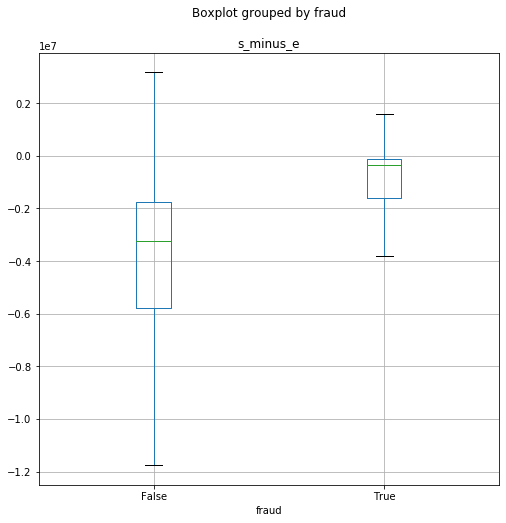

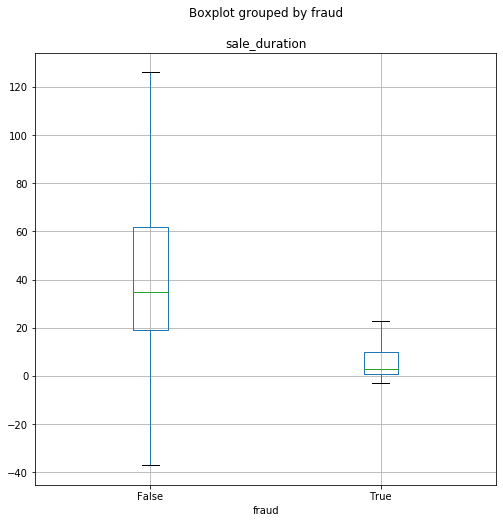

In [369]:
data.boxplot(column=['s_minus_e'], by='fraud', figsize=(8,8), showfliers=False);
data.boxplot(column=['sale_duration'], by='fraud', figsize=(8,8), showfliers=False);

### Identify categorical features & reformat

In [321]:
### How many unique values are in the column?

data_raw[['has_analytics', 'has_header', 'has_logo', 'show_map', 'fb_published', 
      'delivery_method','user_type', 'currency', 'channels', 'org_twitter', 
      'venue_country', 'country', 'org_facebook']].nunique()

has_analytics       2
has_header          2
has_logo            2
show_map            2
fb_published        2
delivery_method     3
user_type           6
currency            7
channels           11
org_twitter        23
venue_country      69
country            72
org_facebook       81
dtype: int64

In [345]:
### 'listed' column : replace 'y' with 1, replace 'n' with 0
data.listed.replace({"y":1, "n": 0}, inplace=True)
#df.listed = df.listed.astype('category')

### 'payout_type' column : "ACH" = 0, "CHECK" = 1, "" = 2
data.payout_type.replace({"ACH": 0, "CHECK": 1, "": 2}, inplace=True)
#df.payout_type = df.payout_type.astype('category', inplace=True)

### 'currency' column : [AUD, CAD, EUR, GBP, MXN, NZD, USD]
### 'currency' column : [AUD, CAD, EUR, GBP, MXN, NZD, USD]
currency_list = ['AUD', 'CAD', 'EUR', 'GBP', 'MXN', 'NZD', 'USD']
currency_codes = {k:v for v, k in enumerate(currency_list)}
data.currency.replace(currency_codes, inplace=True)

### Filling null values 

In [12]:
### Identify columns with null values, and display null count
data.count()[data.count() < 14337].apply(lambda x: 14337 - x)

country              81
delivery_method      16
event_published      99
has_header         5409
org_facebook         59
org_twitter          59
sale_duration       155
venue_country      1076
venue_latitude     1076
venue_longitude    1076
venue_name         1076
venue_state        1076
dtype: int64

In [13]:
sd = data["sale_duration"].mean()
data.sale_duration = data.sale_duration.fillna(sd).astype(int)

In [14]:
fb = data.org_facebook.mean()
data.org_facebook = data.org_facebook.fillna(fb).astype(int)

tw = data.org_twitter.mean()
data.org_twitter = data.org_twitter.fillna(tw).astype(int)

data.delivery_method = data.delivery_method.fillna(2).astype(int)

In [1]:
plt.subplots(1,3)
data.boxplot(column=['org_facebook', 'org_twitter', 'sale_duration'], by='fraud', figsize=(8,8), showfliers=False);

NameError: name 'plt' is not defined

In [16]:
fb, tw, sd

(7.974436195545595, 4.3069757669141335, 46.86969397828233)

## Feature Engineering


<span style="color:magenta">
Note: 'previous_payouts' and 'ticket_types' are dictionaries; some of information is 
not available for future data, so these columns ....
</span>

### Process 'ticket_types' entries

In [19]:
''' 
Sample Ticket Type entry : 

    "[{'event_id': 4848389, 'cost': 45.0, 'availability': 1, 'quantity_total': 80},
    {'event_id': 4848389, 'cost': 20.0, 'availability': 1, 'quantity_total': 50}, 
    {'event_id': 4848389, 'cost': 0.0, 'availability': 1, 'quantity_total': 6}]"
    
'''
def ticket_types(df): 
    #import ast
    
    tt_col = df['ticket_types']
    num_tiers = []
    num_tickets = []
    average_price = []
    
    for row in tt_col:
        #row = ast.literal_eval(row)
        num_tiers.append(len(row))
        quant = []
        price = []
        for dct in row:
            quant.append(dct['quantity_total'])
            price.append(dct['cost'])
        arr = np.array([quant, price])
        average_price.append(np.round((arr[0] * arr[1]).sum()/arr[1].sum(), 2))
        num_tickets.append(int(arr[1].sum()))
        
    df["num_tiers"] = num_tiers
    df["tickets_available"] = num_tickets
    df["average_ticket_price"] = average_price 

In [20]:
ticket_types(data)

/Users/Kelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
data[['num_tiers', 'tickets_available', 'average_ticket_price']].head()

,num_tiers,tickets_available,average_ticket_price
0,3,625,57.60
1,2,70,50.00
2,1,93,48.00
3,6,82,5000.00
4,8,814,35.13


### Process 'previous_payouts' entries

In [371]:
def previous_payouts(df):
    pp_col_value = df.previous_payouts
    avg_payouts = []
    num_payouts = []
    
    for row in pp_col_value:
        num_payouts.append(len(row))

        if len(row) > 0:
            amount = 0
            for dct in row:
                
                amount += dct['amount']
            avg_payouts.append(np.round(amount/len(row), 2))

        else:
            avg_payouts.append(0)
    df["avg_previous_payouts"] = avg_payouts
    df["num_previous_payouts"] = num_payouts

In [372]:
previous_payouts(data)

In [373]:
data[["avg_previous_payouts", "num_previous_payouts"]].head()

,avg_previous_payouts,num_previous_payouts
0,0.00,0
1,16394.36,49
2,1508.40,36
3,208.78,21
4,263.57,49


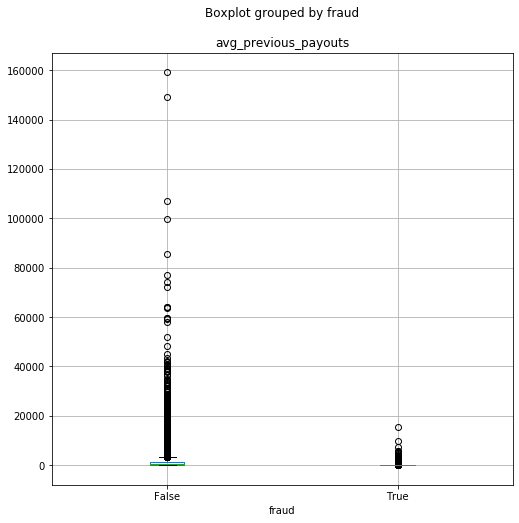

In [376]:
data.boxplot(column=['avg_previous_payouts'], by='fraud', figsize=(8,8), showfliers=True);

### Body Length feature:  
Would this feature be better if HTML formatting is excluded from character count? 

Both fields 'description' and 'org_desc' are text fields with HTML formatting. We know from previous model versions that the 'body_length' field (i.e. the number of characters in 'description') is a useful indicator. Using the **scrub_words** function, we can look at the character count for these fields after the HTML code is removed. 

In [25]:
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("(<.*?>)","",text)
    text=re.sub("rsquo","",text)
    text=re.sub("nbsp","",text)
    text=re.sub("ndash","",text)

    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text=text.strip()
    return text

In [28]:
data.description.fillna('', inplace = True)
data['desc_scrub_len'] = data['description'].apply(lambda x: len(scrub_words(x)))

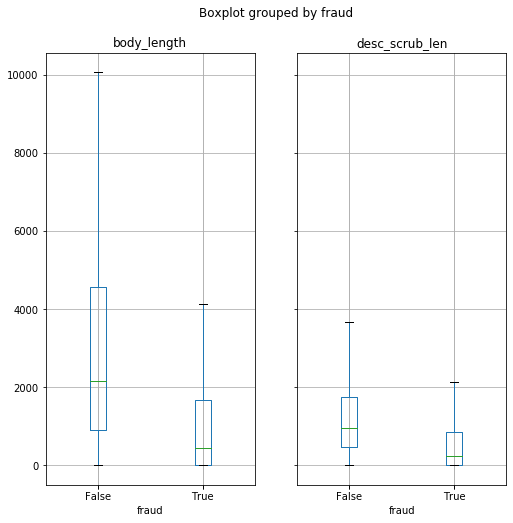

In [29]:
data.boxplot(column=['body_length', 'desc_scrub_len'], by='fraud', figsize=(8,8), showfliers=False);

In [31]:
print(data[data.fraud==False].body_length.median())
print(data[data.fraud==True].body_length.median())
print(data[data.fraud==False].desc_scrub_len.median())
print(data[data.fraud==True].desc_scrub_len.median())

2164.0
452.0
949.0
244.0


### Potential feature: categorize email suffixes

In [32]:
data['email_suffix'] = data.email_domain.str.strip().str.lower().str.extract(r'([^.]+$)')

In [34]:
top10_nf = list(data[data.fraud == False].email_suffix.value_counts().index[:10])
top10_fr = list(data[data.fraud == True].email_suffix.value_counts().index[:10])
print('Most common email suffixes for fraud: ','\n', top10_fr,'\n')
print('Most common email suffixes for non-fraud: ','\n', top10_nf)

Most common email suffixes for fraud:  
 ['com', 'uk', 'fr', 'net', 'ca', 'de', 'vn', 'org', 'biz', 'pw'] 

Most common email suffixes for non-fraud:  
 ['com', 'org', 'uk', 'au', 'ca', 'net', 'edu', 'ly', 'us', 'nz']


In [35]:
top9 = list(data.email_suffix.value_counts().index[:9])
top9

['com', 'org', 'uk', 'au', 'net', 'ca', 'edu', 'fr', 'ly']

In [36]:
email_suffix_list = list(data.email_suffix.value_counts().index)
email_suffix_dict = {}
for idx in range(len(email_suffix_list)):
    if email_suffix_list[idx] in top9:
        email_suffix_dict[email_suffix_list[idx]] = idx
    else:
        email_suffix_dict[email_suffix_list[idx]] = 9

In [37]:
data['email_suffix_code'] = data.copy().email_suffix.apply(lambda x: email_suffix_dict[x])

In [39]:
email_suffix_not = data[data.fraud == False].email_suffix_code.value_counts().reindex(range(10))
email_suffix_fraud = data[data.fraud == True].email_suffix_code.value_counts().reindex(range(10))

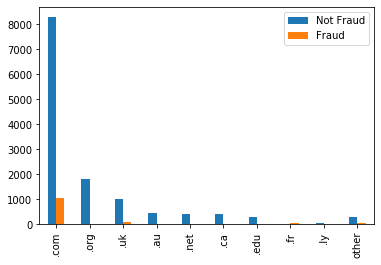

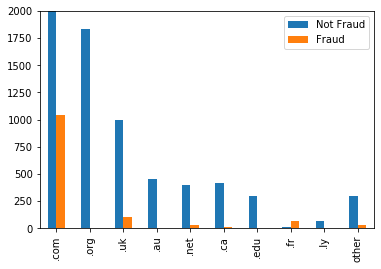

In [40]:
email_NF_count = list(email_suffix_not.values.astype(int))
email_fraud_count = list(email_suffix_fraud.fillna(0).values.astype(int))
index = ['.com', '.org', '.uk', '.au', '.net', '.ca', '.edu', '.fr', '.ly', 'other']
email_df = pd.DataFrame({'Not Fraud': email_NF_count,
                         'Fraud': email_fraud_count}, index = index)

email_df.plot.bar(rot=90)
email_df.plot.bar(rot=90, ylim=[0,2000])
plt.show()

### Potential Feature: Does 'country' match 'venue_country' ?

In [41]:
data['country_match'] = data.country == data.venue_country

In [42]:
NF_matches = [data[(data.fraud == False)&(data.country_match==True)].country_match.count(), data[(data.fraud == False)&(data.country_match==False)].country_match.count()]
fraud_matches = [data[(data.fraud == True)&(data.country_match==True)].country_match.count(), data[(data.fraud == True)&(data.country_match==False)].country_match.count()]

print(NF_matches, fraud_matches)

[10988, 2056] [684, 609]


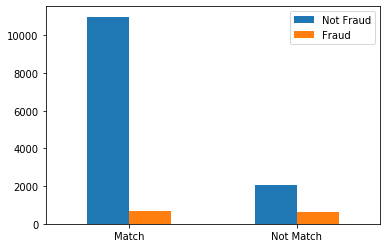

In [43]:
xindex = ['Match', 'Not Match']
xdf = pd.DataFrame({'Not Fraud': NF_matches,
                         'Fraud': fraud_matches}, index = xindex)

xdf.plot.bar(rot=0);

### Potential feature: Length of Organization Description ('org_desc') 

Compare with and without HTML formatting text

In [44]:
### Create column for the length of entry in the organization description (org_desc) field. 
data['org_desc_len'] = data.org_desc.fillna('').str.len()

In [45]:
data['org_desc_scrub_len'] = data['org_desc'].apply(lambda x: len(scrub_words(x)))

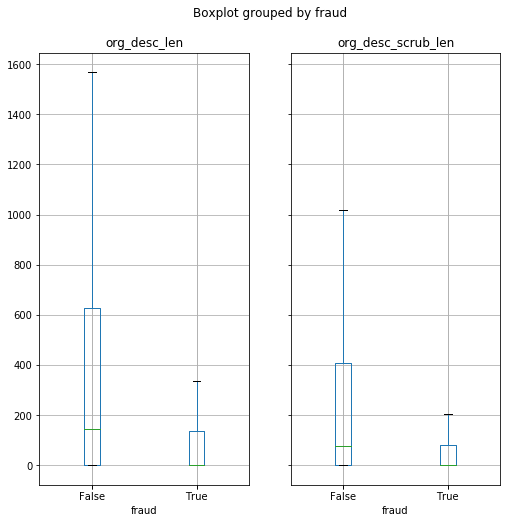

In [47]:
data.boxplot(column=['org_desc_len', 'org_desc_scrub_len'], by='fraud', figsize=(8,8), showfliers=False);

In [49]:
print(data[data.fraud==False].org_desc_len.median())
print(data[data.fraud==True].org_desc_len.median())
print(data[data.fraud==False].org_desc_scrub_len.median())
print(data[data.fraud==True].org_desc_scrub_len.median())

143.5
0.0
77.0
0.0


### Potential feature: Length of Venue Name 

In [50]:
### Create column for the length of entry in the venue_name field. 
data['venue_name_len'] = data['venue_name'].fillna('').str.len()

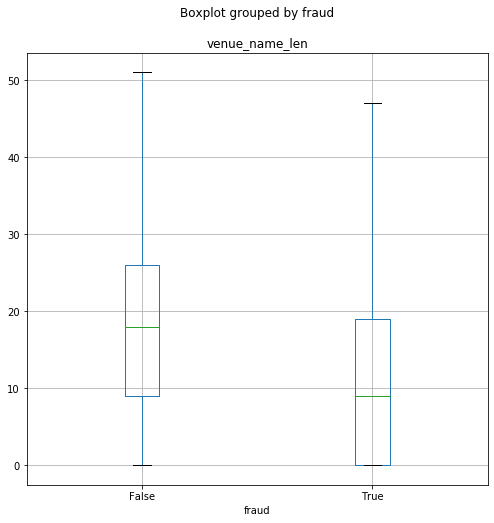

In [51]:
data.boxplot(column=['venue_name_len'], by='fraud', figsize=(8,8), showfliers=False);

### Potential feature: Length of Organization Name ('org_desc') 

In [52]:
data['org_name_len'] = data['org_name'].fillna('').str.len()

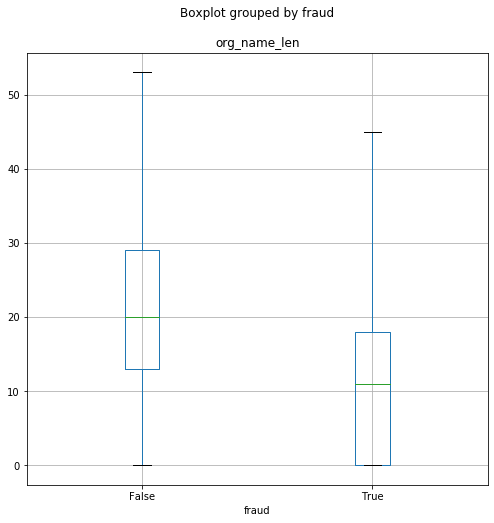

In [53]:
data.boxplot(column=['org_name_len'], by='fraud', figsize=(8,8), showfliers=False);

### Potential feature: Length of Payee Name ('payee_name') 

In [54]:
print(data[data.fraud == False].payee_name.str.len().mean())
print(data[data.fraud == True].payee_name.str.len().mean())

5.15984360625575
0.34184068058778033


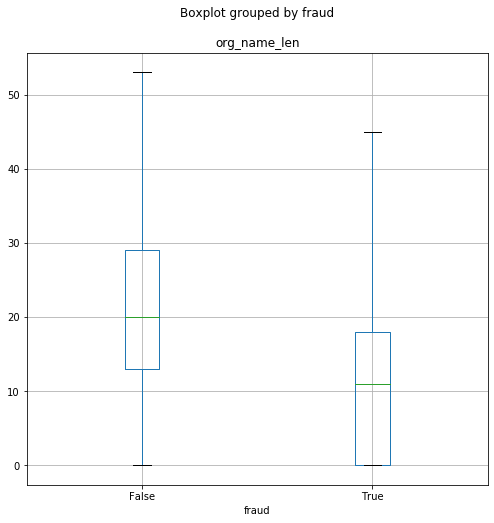

In [55]:
data['org_name_len'] = data['org_name'].fillna('').str.len()
data.boxplot(column=['org_name_len'], by='fraud', figsize=(8,8), showfliers=False);

### Look at possible sources of leakage

Need to fix title so it includes Sale Duration


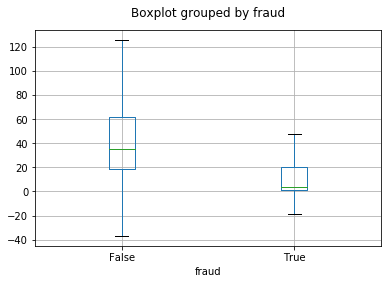

In [287]:
print('Need to fix title so it includes Sale Duration')
data.boxplot(column=['sale_duration'], by='fraud', showfliers=False)
plt.title('');

Need to fix title so it includes User Age


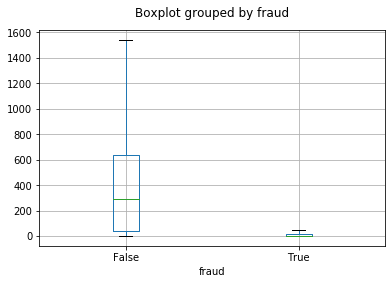

In [286]:
print('Need to fix title so it includes User Age')
data.boxplot(column=['user_age'], by='fraud', showfliers=False)
plt.title('');